# 6.S083 / 18.S190 Spring 2020: Problem set 3

Submission deadline: Tuesday April 21, 2020 at 11:59pm.


In this problem set, we will develop our first proper model that exhibits an **epidemic
outbreak**.

We will develop a **stochastic** (probabilistic) model of an infection propagating in a population  that is **well mixed**, i.e. in which everyone is in contact with everyone else.
An example of this would be a small school or university in which people are
constantly moving around and interacting with each other.

As usual, we will make modelling assumptions that allow us to reach the goal as fast and simply as possible.

The model is an **individual-based** or **agent-based** model -- in other words,
we explicitly keep track of each individual in the population and what their
infection status is. However, we will not keep track of their position in space;
we will just assume that there is some mechanism by which they interact with
other individuals which we do not include in the model (for now).

## Exercise 1: Modelling the spread of an infection or rumour

In this exercise we will model the spread of an infection or rumour in which
there is no recovery via a stochastic model, which we will implement in a Monte Carlo
simulation (i.e. a simulation that involves generating random numbers).

We will call the individuals **agents**.


1. Julia has a data type called an [**enumerated type**](https://en.wikipedia.org/wiki/Enumerated_type). Variables of this type can only take one of a pre-defined set of values; we will use this to model the possible internal state of an agent.

    The code to define an enum is as follows:

    ```julia
    @enum InfectionStatus S I R
    ```

    This defines a new type `InfectionStatus`, as well as names `S`, `I` and `R` that are the only possible values that a variable of this type can take.

    Define a variable `x` equal to `S`. What is its type?

2. Convert `x` to an integer using the `Int` function. What value does it have? What values do `I` and `R` have?

3. Take $N=100$. Make an array `agents` whose $i$th entry is the status of agent
number $i$. Make them all initially susceptible.

4. Now choose a single agent at random and make it infectious. (Hint: Use the
    `rand` function with a range to choose the index of the infectious agent.)

5. Write a function `step!` that takes a `Vector` `agents` and a probability `p_I`
as arguments.  This function may *modify* the content of `agents` to implement one step of the infection dynamics.

    1. Choose an agent $i$ at random.
    2. If $i$ is not infectious then nothing happens on this step so you can just `return`
 from the function.
     3. Choose another agent $j$ at random. Make sure that $i \neq j$. To do so, repeat this
    choice *until* $i \neq j$.
    4. If $j$ is susceptible then $i$ infects $j$ with probability $p_I$.

6. Write a function `sweep!` which takes arguments `agents` and `p_I`$. It runs `step!` $N$ times, where $N$ is the number of agents. Thus each agent acts, on average, once per sweep. One sweep is thus the unit
of time in our Monte Carlo simulation.

7. Write a function `infection_simulation`. It should take $N$ and $p_I$ as arguments,
as well as $T$, the total number of steps.

    1. First generate the `Vector` `agents` of length $N$, picking one to be initially infected, and a `Vector` `Is` to store
    the number of infectious individuals at each step.

    2. Run `sweep!` a number $T$ of times. Calculate the total number of infectious
    agents at the end of each step and store that number in `Is`.

    3. Return `Is` as the output of the function.

8. Run your simulation 50 times with $N=100$ and collect the data in a `Vector` of `Vector`s called `results`, using $p_I = 0.02$ and $T = 1000$.

    Plot each of the 50 graphs on the same plot using transparency 0.5.

9. Calculate the mean trajectory using the `mean` function applied to `results`. [This "just works" since `mean` is implmented in a generic way!] Add it to the plot using a heavier line.

10. Calculate the standard deviation $\sigma$ of $I$ at each step. [This should thus be a *vector.] Add this to the plot using **error bars**, using the option `yerr=σ` in the plot command; use transparency.

    This should confirm that the distribution of $I$ at each step is pretty wide!

9. You should see that the mean behaves in a similar way to what we saw in lectures using a *deterministic* model. So what is the deterministic model possibly describing, in terms of the stochastic model?

In [ ]:
#using Gadfly,

In [1]:
using Statistics,Plots

In [2]:
@enum InfectionStatus S I R
x = S
@show Int(x)

Int(x) = 0


0

In [3]:
N = 100
agents = [S for _ in 1:N]
agents[@show rand(1:N)] = I


rand(1:N) = 48


I::InfectionStatus = 1

In [4]:
pick(agent) = rand(1:length(agent))

pick (generic function with 1 method)

In [5]:
function step!(agent,p_I)
    pick1 = pick(agent)
    if Int(agent[pick1]) == 0
        return 
    end
    pick2 = pick(agent)
    while pick2 == pick1
        pick2 = pick(agent)
    end
    if rand() < p_I
        agent[pick2] = I
    end
    #@show pick1, pick2
end

step! (generic function with 1 method)

In [6]:
function sweep!(agent,p_I)
    N = length(agent)
    for i in 1:N
        step!(agent,p_I)
    end
end

sweep! (generic function with 1 method)

In [7]:
function infection_simulation(N,p_I,T)
    agents = [S for _ in 1:N]
    agents[rand(1:N)] = I
    Is = zeros(T)
    for t in 1:T
        sweep!(agents,p_I)
        Is[t] = sum(Int.(agents) .== 1 )
    end
    return Is
end

infection_simulation (generic function with 1 method)

In [8]:
res = infection_simulation(100,0.02,1000)

1000-element Vector{Float64}:
   1.0
   1.0
   1.0
   1.0
   1.0
   1.0
   1.0
   1.0
   1.0
   1.0
   1.0
   1.0
   1.0
   ⋮
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0

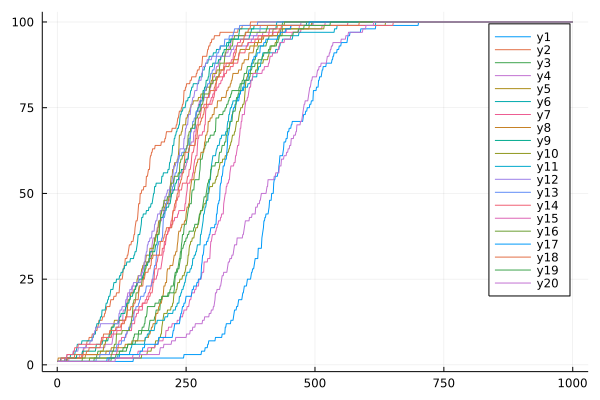

In [12]:
p = plot()
for _ in 1:20
    plot!(1:1000,infection_simulation(100,0.02,1000))
end
p

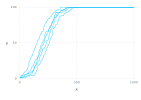

In [47]:
function run_plot()
    res = infection_simulation(100,0.02,1000)
    return layer(x=1:1000,y=res,Geom.line)
end
#layers = [run_plot() for _ in 1:5]
#plot(layers...)

## Exercise 2: Agent type

Suppose we want to track more information about each agent, e.g. how many other agents were infected by that agent. We could just create an additional array with that information in, but we will need to pass that around and will start to lose track of what belongs together.

Instead a good solution is to define a custom composite type.


1. Define a mutable type `Agent` as follows:

    ```jl
    mutable struct Agent
        status::InfectionStatus
        num_infected::Int
    end
    ```

2. Define a method of the constructor of `Agent` that takes no arguments and sets the status to `S` and
the number infected to 0.


3. Rewrite your code from Exercise 1 to use the new `Agent` type. Now when your functions accept an `agents`
vector, they should assume that that represents a `Vector` of `Agent` objects.

    You can enforce this using a function signature like

    ```jl
    function f(agents::Vector{Agent})
    end
    ```

    You should call your main function `num_infected_dist_simulation`, where you create an array `agents` of `Agent`s of size $N=100$ and set the first one's infection status to `I`.

4. Update an agent's `num_infected` field whenever it infects another agent.

5. At the end of the simulation, extract the probability distribution of the "number of agents infected", using your code from Exercise 1 of Problem Set 2. This should be returned from `num_infected_dist_simulation`.

7. Average the distribution over 50 simulations and plot the result. What kind of distribution does it seem to be? You will need to think about how to visualize this.

In [32]:
function counts(data::Vector)
  d = Dict{Int,Int}()
  for i in data
    haskey(d,i) ? d[i] +=1 : d[i] = 1
  end
  ks = collect(keys(d))
  vs = collect(values(d))
  p = sortperm(ks)
  #return [ks[p] ;; vs[p]]
  return Dict(zip(ks[p],vs[p]))
end

counts (generic function with 2 methods)

In [13]:
mutable struct Agent
        status::InfectionStatus
        num_infected::Int
    end

In [14]:
Agent() = Agent(S,0) 

Agent

In [67]:
function step!(agent::Vector{Agent},p_I)
    pick1 = pick(agent)
    if agent[pick1].status == S
        return 
    end
    pick2 = pick(agent)
    while pick2 == pick1
        pick2 = pick(agent)
    end
    if rand() < p_I && agent[pick2].status == S
        agent[pick2].status = I
        agent[pick1].num_infected += 1 
    end
    #@show pick1, pick2
end

step! (generic function with 3 methods)

Do-while in Julia
```Julia
while true
    # do stuff
    cond() || break
end
```

In [17]:
function sweep!(agent::Vector{Agent},p_I)
    N = length(agent)
    for i in 1:N
        step!(agent,p_I)
    end
end

sweep! (generic function with 2 methods)

In [35]:
function num_infected_dist_simulation(N,p_I,T)
    agents = [Agent() for _ in 1:N]
    agents[rand(1:N)].status = I
    #Is = zeros(T)
    for t in 1:T
        sweep!(agents,p_I)
        #Is[t] = sum(Int.(agents.status) .== 1 )
        
    end
    num_infected = [x.num_infected for x in agents]
    return num_infected
end

    

num_infected_dist_simulation (generic function with 1 method)

In [60]:
?histogram

search: histogram histogram! histogram2d histogram2d!



```
histogram(x)
histogram!(x)
```

Plot a histogram.

# Arguments

  * `x`: AbstractVector of values to be binned
  * `bins`: Integer, NTuple{2,Integer}, AbstractVector or          Symbol. Default is :auto (the Freedman-Diaconis rule). For          histogram-types, defines the approximate number of bins to aim for,          or the auto-binning algorithm to use (:sturges,          :sqrt, :rice, :scott or :fd). For fine-grained control          pass a Vector of break values, e.g. `range(minimum(x),          stop = maximum(x), length = 25)`
  * `weights`: Vector of weights for the values in `x`, for weighted bin counts
  * `normalize`: Bool or Symbol. Histogram normalization mode.               Possible values are: false/:none (no normalization,               default), true/:pdf (normalize to a discrete               Probability Density Function, where the total area of the               bins is 1), :probability (bin heights sum to 1)               and :density (the area of each bin, rather than               the height, is equal to the counts - useful for               uneven bin sizes).
  * `bar_position`: Symbol.  Choose from `:overlay` (default),                  `:stack`.  (warning: May not be implemented fully)
  * `bar_width`: nothing or Number. Width of bars in data               coordinates. When nothing, chooses based on x (or y when               `orientation = :h`).
  * `bar_edges`: Bool.  Align bars to edges (true), or centers               (the default)?
  * `orientation`: Symbol.  Horizontal or vertical orientation                 for bar types.  Values `:h`, `:hor`,                 `:horizontal` correspond to horizontal (sideways,                 anchored to y-axis), and `:v`, `:vert`, and                 `:vertical` correspond to vertical (the default).

# Example

```julia-repl
julia> histogram([1,2,1,1,4,3,8],bins=0:8)
julia> histogram([1,2,1,1,4,3,8],bins=0:8,weights=weights([4,7,3,9,12,2,6]))
```


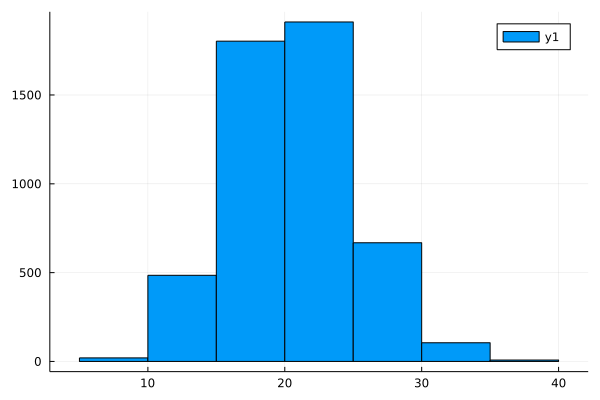

In [64]:
tmp = vcat([num_infected_dist_simulation(100,0.02,1000) for _ in 1:50]...)
histogram(tmp,bins = 10)

## Exercise 3: Epidemic model

1. Add recovery to your model using an additional
parameter `p_R` in the `step!` and related functions.

    In each sweep, each agent should check if it is infected, and if so it
    recovers with probability $p_R$.

    The function `simulation_with_recovery` should return vectors `Ss`, `Is` and `Rs` giving the time evolution of the numbers of $S$, $I$ and $R$, as well as the probability distribution of number of people infected.

2. Run the simulation with $N=1000$, $p_I = 0.1$ and $p_R = 0.01$ for time $T=1000$. Plot $S$, $I$ and $R$ as a function of time. You should see graphs that look familiar from the internet, with an epidemic outbreak, i.e. a significant fraction of infectious agents after a short time, which then recover.

3. Plot the distribution of `num_infected`. Does it have a recognisable shape?

4. Run the simulation 50 times and plot $I$ as a function of time for each, together with the mean over the 50 simulations (as you did in Exercise 2).

5. Describe 3 ways in which you could characterize the magnitude of the epidemic. Find these quantities for one of the runs of your simulation.

In [66]:
function step!(agent::Vector{Agent},p_I,p_R)
    pick1 = pick(agent)
    if agent[pick1].status == S
        return 
    end
    if rand() > p_R
        pick2 = pick(agent)
        while pick2 == pick1
            pick2 = pick(agent)
        end
        if rand() < p_I && agent[pick2].status == S
            agent[pick2].status = I
            agent[pick1].num_infected += 1 
        end
    else 
        agent[pick1].status = R
    end
    #@show pick1, pick2
end

step! (generic function with 3 methods)

In [68]:
function sweep!(agent::Vector{Agent},p_I,p_R)
    N = length(agent)
    for i in 1:N
        step!(agent,p_I,p_R)
    end
end

sweep! (generic function with 3 methods)

In [ ]:
function simulation_with_recovery(N,p_I,p_R,T)
    agents = [S for _ in 1:N]
    agents[rand(1:N)] = I
    Ss, Is, Rs = Vector{Int64}(undef,T),Vector{Int64}(undef,T),Vector{Int64}(undef,T)
    for idx in 1:T
        sweep!(agents,p_I,p_R)
        Ss[idx] = count(agents .== S)
        Is[idx] = count(agents .== I)
        Rs[idx] = count(agents .== R)
    end
    return Ss,Is,Rs
end
